This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        2
Number of nonzeros in inequality constraint Jacobian.:     1200
Number of nonzeros in Lagrangian Hessian.............:        2

Total number of variables............................:      204
                     variables with only lower bounds:      201
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:      201
        inequality constraints with only lower bounds:      200
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        1

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  9.9999900e-03 1.00e+00 2.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

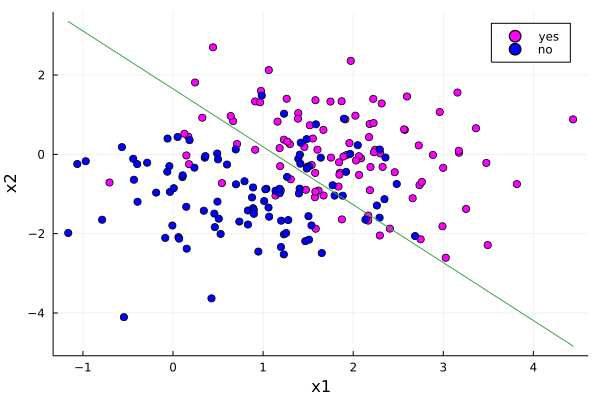

In [2]:
using DataFrames, CSV, LinearAlgebra
using Plots, StatsModels, StatsBase
using JuMP, Ipopt

function svm1(A, y; C=100)  # separable data, but nonlinear constraint
    (m,n) = size(A)
    model = Model(Ipopt.Optimizer)
    @variable(model, M >= 0)       # the margin
    @variable(model, β[1:n])       # model parameters
    @variable(model, s[1:m] >= 0); # slack variables

    @NLconstraint(model, sum(β[i]^2 for i in 2:n) == 1)
    for i in 1:m
        @constraint(model, y[i]*(β'*A[i,:]) >= M-s[i])
    end
    @constraint(model, sum(s[i] for i in 1:m) <= C)

    @objective(model, Max, M)

    optimize!(model)
    println("objective value = ", objective_value(model))
    println("solution = ", value.(β))
    return value.(β)
end

# two-class data
df = CSV.read("two-class-data.csv", DataFrame)

fo = @formula(y ~ 1 + x1 + x2)
A = modelmatrix(fo.rhs, df)
y = vec(modelmatrix(fo.lhs, df))

β = svm1(A, y; C=25)         # obtain the model parameters

f(x) = (-β[1] - β[2]*x)/β[3] # decision boundary helper function

yes = findall(x->x==1, y)    # indices for the +1 class
no  = findall(x->x==-1, y)   # indices for the -1 class

# plot the data and the decision boundary
scatter(df.x1[yes], df.x2[yes], color=:magenta, label="yes", fmt = :png)
scatter!(df.x1[no], df.x2[no], color=:blue, label="no")
plot!(df.x1, f.(df.x1), label="", xlabel="x1", ylabel="x2")



This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1000
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:      203
                     variables with only lower bounds:      200
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      201
        inequality constraints with only lower bounds:      200
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        1

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 9.90e-01 1.75e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

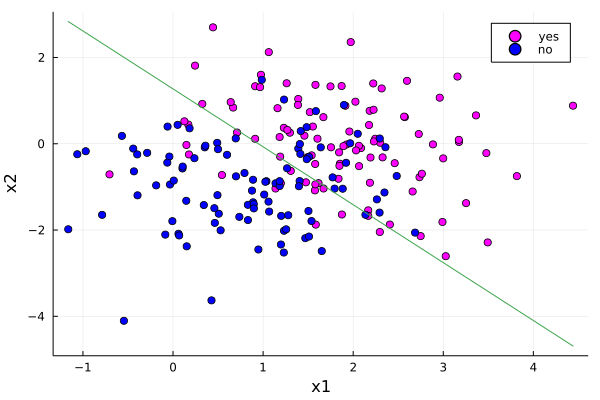

In [3]:
### a ###
function svm2(A, y; C=100)
    (m,n) = size(A)
    model = Model(Ipopt.Optimizer)
    @variable(model, β[1:n])       # model parameters
    @variable(model, s[1:m] >= 0); # slack variables

    for i in 1:m
        @constraint(model, y[i]*(β'*A[i,:]) >= 1-s[i])
    end
    @constraint(model, sum(s[i] for i in 1:m) <= C)

    @NLobjective(model, Min, (sum(β[i] for i in 2:n))^2)

    optimize!(model)
    println("objective value = ", objective_value(model))
    println("solution = ", value.(β))
    return value.(β)
end

β = svm2(A, y; C=100)         # obtain the model parameters

f(x) = (-β[1] - β[2]*x)/β[3] # decision boundary helper function

yes = findall(x->x==1, y)    # indices for the +1 class
no  = findall(x->x==-1, y)   # indices for the -1 class

# plot the data and the decision boundary
scatter(df.x1[yes], df.x2[yes], color=:magenta, label="yes", fmt = :png)
scatter!(df.x1[no], df.x2[no], color=:blue, label="no")
plot!(df.x1, f.(df.x1), label="", xlabel="x1", ylabel="x2")

In [ ]:
# The function svm2 produces a support vector classifier with the solution being
# 0 = β1 + β2 * x1 + β3 * x2 = -0.8536475893779484 + 0.9014179967371914 * x1 + 0.6713783529198196 * x2.
# The decision boundry attempts to classify "yes" responses above the boundry and "no" responses below.

In [6]:
### b ###
function get_number_misclassified(β)
    misclass_count = 0  
    for i in 1:length(y)
        if y[i]*(transpose(β)*A[i,:]) < 0
            misclass_count += 1
        end
    end
    return misclass_count
end

β1 = svm2(A, y; C=150)
β2 = svm2(A, y; C=175)
β3 = svm2(A, y; C=200)
println("C = 150, number of misclassified observation = ", get_number_misclassified(β1))
println("C = 175, number of misclassified observation = ", get_number_misclassified(β2))
println("C = 200, number of misclassified observation = ", get_number_misclassified(β3))

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1000
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:      203
                     variables with only lower bounds:      200
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      201
        inequality constraints with only lower bounds:      200
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        1

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 9.90e-01 1.75e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

C = 150, number of misclassified observation = 44
C = 175, number of misclassified observation = 71
C = 200, number of misclassified observation = 94


In [ ]:
# This shows that when C is increased, there will tend to be a higher misclassification rate because there is a higher 
# tolerance of violations.

In [ ]:
### c ###
# When C is small there are narrow margins that not very tolerant to violations to the margin meaning their is a 
# high varience and low bias.
# When C is larger there are wider margins with a low bias and a high varience. This means that there is a higher 
# tolerance of violations. This can be seen in part B with using a C=200 results in 94 misclassified obserations.